In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important; }</style>"))

In [2]:
# import libraries

import sys
import os
import time
import gc
import numpy as np
import numpy.matlib
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sklearn as sk
import sklearn.decomposition
import skimage.draw
import scipy
import scipy.signal
import pandas as pd

import multiprocessing
from multiprocessing import Pool

import imageio

import pywavesurfer.ws

from pathlib import Path

In [3]:
# sys.path.insert(0, 'G:\My Drive\Research\Sabatini Lab Stuff - working\Code\PYTHON functions')
# sys.path.insert(0, '/media/rich/Home_Linux_partition1/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON functions')
from bmi_idap.helpers.getVideoDirectoryProperties import getVideoDirectoryProperties

In [4]:
print(os.environ['CONDA_DEFAULT_ENV'])

rapids-0.19


In [5]:
sys.path.append('/media/rich/Home_Linux_partition/github_repos/')

In [17]:
%load_ext autoreload
%autoreload 2
from NBAP import import_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
dir_S2p             = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/suite2p/plane0')

dir_ROIClassifier   = Path(r'/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/analysis_lastNight')

dir_ws              = Path(r'/media/rich/bigSSD/res2p/wavesurfer data/round 5 experiments/mouse 2_6/20210417')
fileName_ws         = Path(r'exp_0001.h5')

dir_cameraCSV       = Path(r'/media/rich/bigSSD/res2p/Camera data/round 5 experiments/mouse 2_6/20210417/cam3/experiment')
fileName_cameraCSV  = Path(r'times_cam32021-04-18T00_41_02.csv')

dir_faceRhythm      = Path(r'/media/rich/bigSSD/analysis_data/mouse 2_6/20210417/FR_run1/data')
fileName_faceRhythm = Path('factors_spectral_temporal_interp.npy')

# directory to save outputs from this notebook
dir_save            = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/postHoc_analysis') 

In [25]:
F , Fneu , iscell , ops , spks , stat , num_frames_S2p = import_data.import_S2p(dir_S2p)

IsCell_ROIClassifier , ROI_Classifier_manual_selection_vars = import_data.import_roiClassifier(dir_ROIClassifier)

ws_data = import_data.import_ws(Path(dir_ws) / Path(fileName_ws))

cameraCSV , signal_GPIO = import_data.import_cameraCSV(Path(dir_cameraCSV) / Path(fileName_cameraCSV))

temporalFactors_faceRhythm = import_data.import_temporalFactorsFR(Path(dir_faceRhythm) / Path(fileName_faceRhythm))

In [129]:
%load_ext autoreload
%autoreload 2
from NBAP import align_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


frames in scanimage movie = 108000
frames from ws galvo extraction movie = 108000
number of wavesurfer samples per imaging frame:  33.36288888888889
Completed aligning WS to S2p. Total elapsed time: 0.11 seconds
Completed aligning Licks to S2p. Total elapsed time: 4.43 seconds
Completed aligning Rewards to S2p. Total elapsed time: 4.41 seconds
Completed aligning Treadmill to S2p. Total elapsed time: 0.44 seconds
Completed extracting camera pulses from camera data. Total elapsed time: 0.04 seconds
Completed aligning camera pulses to S2p. Total elapsed time: 0.19 seconds
Completed converting camera dates from camera data to absolute time. Total elapsed time: 0.09 seconds
Completed aligning camera frames to wavesurfer. Total elapsed time: 0.0 seconds
total elapsed time: 0.19 seconds


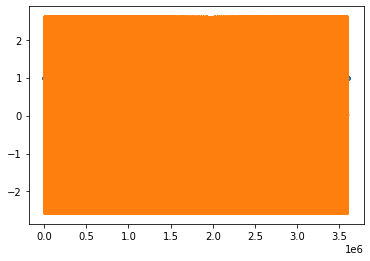

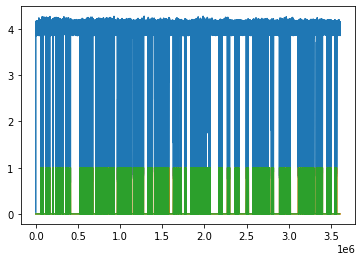

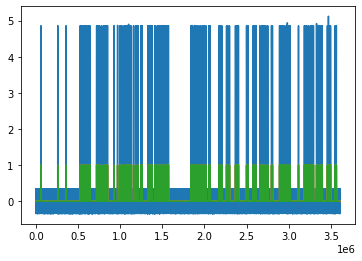

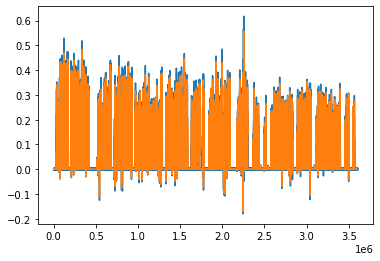

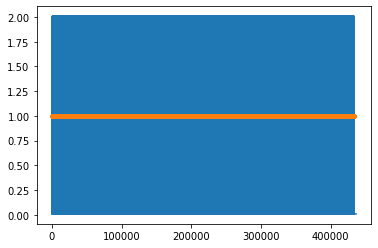

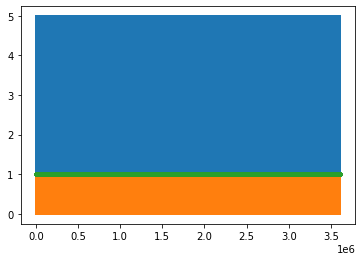

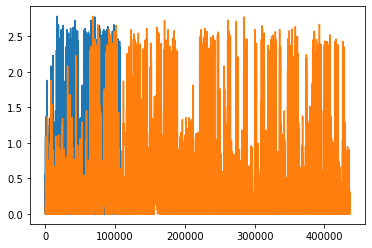

In [132]:
## == ALIGN DATA ==
%matplotlib inline

ws_galvoFlyBackTrace = ws_data[6,:] 
ws_YGalvoFlybacks_bool_wsTime , ws_frameTimes_wsTime , ws_samples_per_S2p_frame_rough = align_data.align_ws_toS2p(ws_galvoFlyBackTrace , num_frames_S2p , True)

ws_licks = ws_data[3,:]
thresh_licks = -0.2
ws_licks_bool_wsTime , ws_licks_bool_S2pInd , ws_lickTimes_S2pInd = align_data.align_licks_toS2p(ws_licks , thresh_licks , ws_frameTimes_wsTime , num_frames_S2p , True)

ws_rewards = ws_data[4,:]
thresh_rewards = 1
ws_rewards_bool_wsTime , ws_rewards_bool_S2pInd , ws_rewardTimes_S2pInd = align_data.align_rewards_toS2p(ws_rewards , thresh_rewards , ws_frameTimes_wsTime , num_frames_S2p , True)

ws_treadmill = ws_data[2,:]
ws_treadmill_S2pInd = align_data.align_treadmill_toS2p(ws_treadmill , ws_frameTimes_wsTime , num_frames_S2p , ws_samples_per_S2p_frame_rough , True)

signal_GPIO_bool_camTime , signal_GPIO_camTimes = align_data.extract_camPulses_camIdx(signal_GPIO , True)

ws_camPulses = ws_data[0,:]
ws_camSignal_bool_wsTime , ws_camSignal_wsTimes = align_data.align_ws_camPulses_toWS(ws_camPulses , True)

camTimeDates = cameraCSV[:,3]
camTimes_absolute = align_data.convert_camTimeDates_toAbsoluteSeconds(camTimeDates)

camTimes_wsInd , camTimes_wsInd_rounded , first_camPulse_camIdx , last_camPulse_camIdx = align_data.align_camFrames_toWS(signal_GPIO_camTimes , camTimes_absolute , ws_camSignal_wsTimes)

camSignal_s2pInd , first_s2pIdx_usable = align_data.align_camSignal_toS2p_andToWS(temporalFactors_faceRhythm , camTimes_wsInd , len(signal_GPIO) , ws_frameTimes_wsTime , first_camPulse_camIdx , last_camPulse_camIdx , True)

In [134]:
signals_S2pAligned = {
    "ws_licks_bool_S2pInd": ws_licks_bool_S2pInd,
    "ws_rewards_bool_S2pInd": ws_rewards_bool_S2pInd,
    "ws_treadmill_S2pInd": ws_treadmill_S2pInd,
    "ws_rewards_bool_S2pInd": ws_rewards_bool_S2pInd,
    "camSignal_s2pInd": camSignal_s2pInd,
}

alignment_data = {
    "ws_YGalvoFlybacks_bool_wsTime": ws_YGalvoFlybacks_bool_wsTime,
    "ws_frameTimes_wsTime": ws_frameTimes_wsTime,
    "ws_samples_per_S2p_frame_rough": ws_samples_per_S2p_frame_rough,
    
    "thresh_licks": thresh_licks,
    "ws_licks_bool_wsTime": ws_licks_bool_wsTime,
    "ws_licks_bool_S2pInd": ws_licks_bool_S2pInd,
    "ws_lickTimes_S2pInd": ws_lickTimes_S2pInd,
    
    "thresh_rewards": thresh_rewards,
    "ws_rewards_bool_wsTime": ws_rewards_bool_wsTime,
    "ws_rewards_bool_S2pInd": ws_rewards_bool_S2pInd,
    "ws_rewardTimes_S2pInd": ws_rewardTimes_S2pInd,
    
    "ws_treadmill_S2pInd": ws_treadmill_S2pInd,
    
    "signal_GPIO_bool_camTime": signal_GPIO_bool_camTime,
    "signal_GPIO_camTimes": signal_GPIO_camTimes,
    
    "ws_camSignal_bool_wsTime": ws_camSignal_bool_wsTime,
    "ws_camSignal_wsTimes": ws_camSignal_wsTimes,
    
    "camTimes_absolute": camTimes_absolute,
    
    "camTimes_wsInd": camTimes_wsInd,
    "camTimes_wsInd_rounded": camTimes_wsInd_rounded,
    "first_camPulse_camIdx": first_camPulse_camIdx,
    "last_camPulse_camIdx": last_camPulse_camIdx,
    
    "camSignal_s2pInd": camSignal_s2pInd,
    "first_s2pIdx_usable": first_s2pIdx_usable,
}

<IPython.core.display.Javascript object>


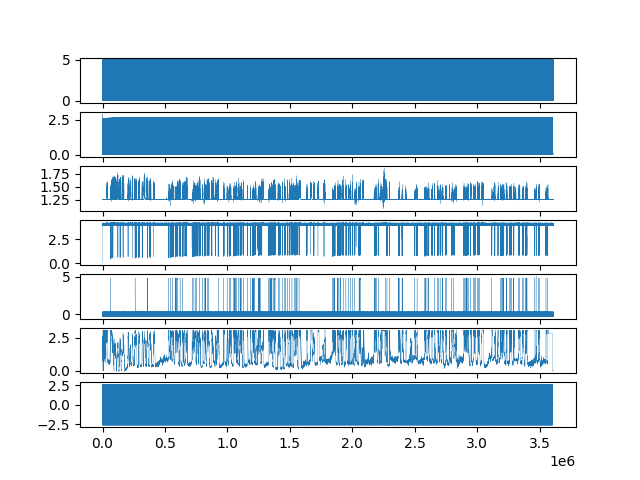

In [35]:
# show wavesurfer data

%matplotlib notebook
fig , axs = plt.subplots(ws_data.shape[0] , sharex=True)
for ii in range(ws_data.shape[0]):
    axs[ii].plot(ws_data[ii,:] , linewidth=0.2)

In [39]:
### Make dFoF and zscored stuff
tic = time.time()
# F_neuSub = F - 0.7*Fneu
# F_baseline_static = np.percentile(F_neuSub,30)
# dF = F_neuSub - F_baseline_static
# dFoF = dF / F_baseline_static

F_zscore = scipy.stats.zscore(F, axis=1)
# spks_zscore = scipy.stats.zscore(spks, axis=1)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

total elapsed time: 3.31 seconds


In [49]:
## Make rolling baseline subtraction
from bmi_idap.helpers import welford_moving_2D
import tqdm
from tqdm import trange

# list_of_values = [3, 5, 8, 10, 4, 8, 12, 15, 11, 9]
F_mean_rolling = np.ones_like(F.T) * np.nan
F_var_rolling = np.ones_like(F.T) * np.nan
win_size_rollingBaseline = round(60 * 30 * 10)
list_of_values = F.T
varSum_old = None
mean_old = None
for idx in trange(len(list_of_values)):

    mean_new = welford_moving_2D.update_mean(idx, list_of_values, win_size_rollingBaseline, mean_old)
    varSum_new = welford_moving_2D.update_varSum(idx, list_of_values, win_size_rollingBaseline, varSum_old)
    var_new = welford_moving_2D.varSum_to_var(idx, list_of_values, win_size_rollingBaseline, mean_new, varSum_new)

    F_mean_rolling[idx,:] = mean_new
    F_var_rolling[idx,:] = var_new
#     msg = "SMA=%.4f, PSA=%.4f, Var=%.4f" % (mean_new, varSum_new, var_new)
#     print("bar %i: %s" % (idx, msg))

    mean_old = mean_new
    varSum_old = varSum_new

eps = 1e-7
F_var_rolling[F_var_rolling<eps] = eps
F_zscore_roll = (list_of_values - F_mean_rolling)/np.sqrt(F_var_rolling)

100%|██████████| 108000/108000 [01:14<00:00, 1445.32it/s]


In [50]:
## == REGRESSION ANALYSIS

<IPython.core.display.Javascript object>


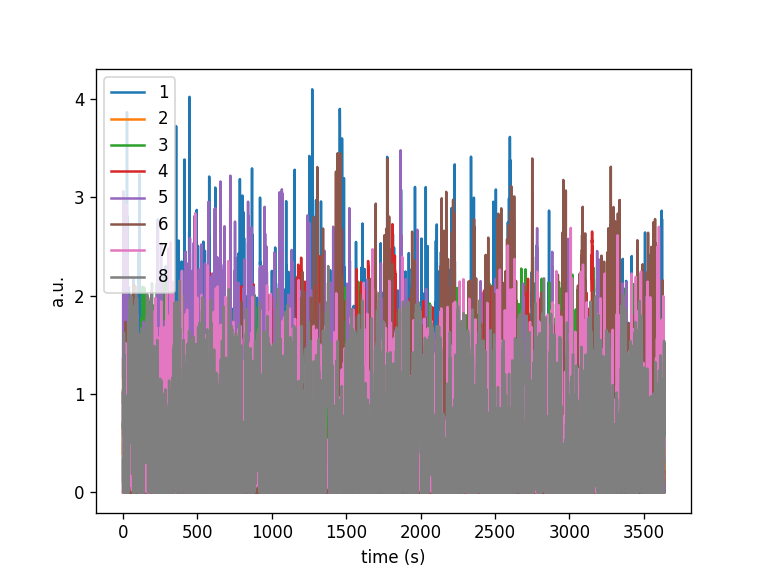

Text(0, 0.5, 'a.u.')

In [51]:
%matplotlib notebook

factors_toUse = temporalFactors_faceRhythm
modelRank = factors_toUse.shape[1]
## just for plotting in case 
if 'Fs' not in globals():
    Fs = 120

plt.figure()
# plt.plot(np.arange(factors_toUse.factors(4)[0][2].shape[0])/Fs , factors_toUse.factors(4)[0][2])
# factors_temporal = scipy.stats.zscore(factors_toUse[2][:,:] , axis=0)
factors_temporal = factors_toUse[:,:]
# factors_temporal = scipy.stats.zscore(factors_temporal_reconstructed , axis=0)
# plt.plot(np.arange(factors_temporal.shape[0])/Fs, factors_temporal[:,:])
plt.plot(np.arange(factors_temporal.shape[0])/Fs, factors_temporal[:,])
# plt.plot(factors_temporal[:,:])
plt.legend(np.arange(modelRank)+1)
plt.xlabel('time (s)')
plt.ylabel('a.u.')

<IPython.core.display.Javascript object>


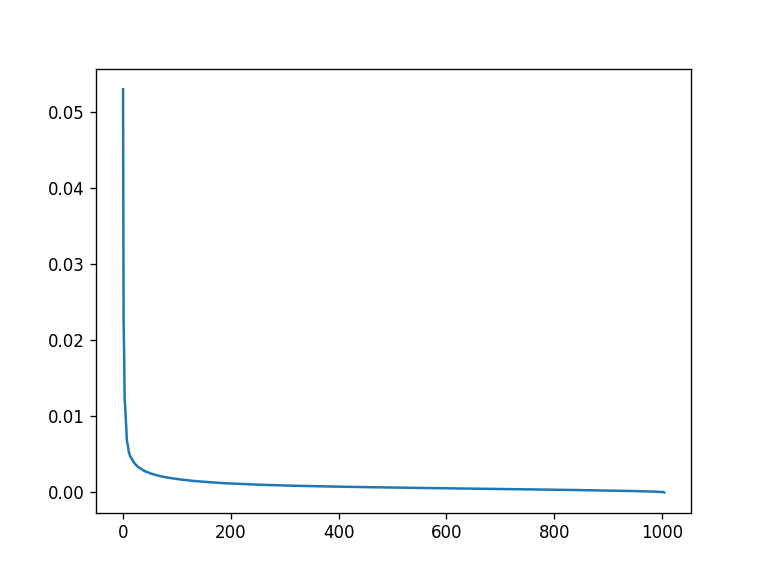

In [52]:
input_dimRed = F_zscore_roll[:,IsCell_ROIClassifier==True]
n_components = input_dimRed.shape[1]
pca = sk.decomposition.PCA(n_components=n_components)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
pca.fit(np.single(input_dimRed).transpose())
output_PCA = pca.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

output_PCA.shape
plt.figure()
plt.plot(pca.explained_variance_ratio_)

In [53]:
output_PCA[:,1:].shape

(108000, 1004)

<IPython.core.display.Javascript object>


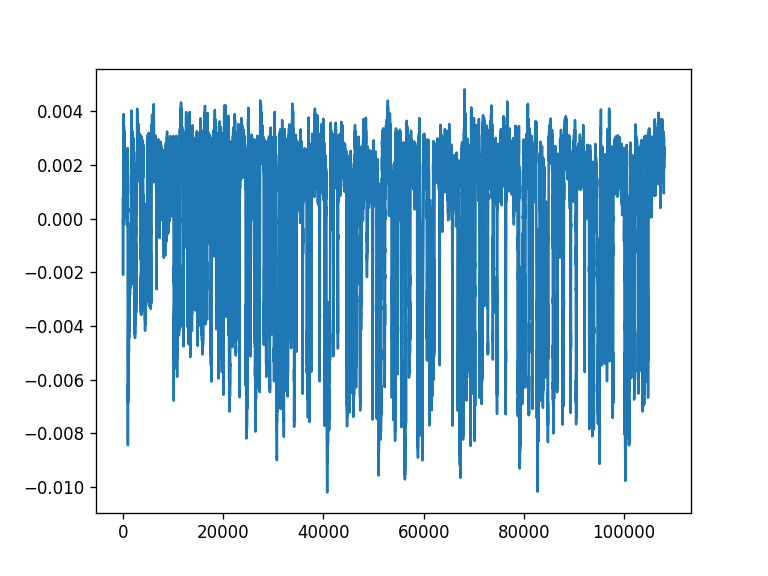

In [54]:
plt.figure()
plt.plot(output_PCA[:,0])

In [227]:
%matplotlib inline
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
#                           np.random.uniform(low=0.9, high=1)) for i in xrange(nlabels)]
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
#                           np.random.uniform(low=low, high=high)) for i in xrange(nlabels)]
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

In [230]:
# import sklearn.linear_model
# from catboost import CatBoostRegressor
from tqdm import tqdm

num_factors = temporalFactors_s2pInd.shape[1]

X_input = scipy.signal.savgol_filter( spks[IsCell_ROIClassifier==True,:].T , 31 , 3 , axis=0)
X_input[X_input<0] = 0
X_input = scipy.stats.zscore(X_input , axis=0)

y_input = temporalFactors_s2pInd[:,:]

In [246]:
X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = copy.deepcopy(y_input)

Number of labels: 30


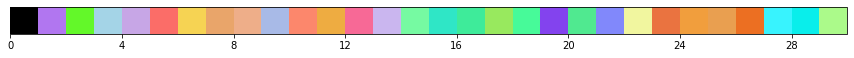

In [232]:
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
                                     StratifiedKFold, GroupShuffleSplit,
                                     GroupKFold, StratifiedShuffleSplit)


np.random.seed(1338)
cmap_data = plt.cm.Accent
# cmap_data = plt.cm.coolwarm
# cmap_cv = plt.cm.coolwarm

# Generate the class/group data
Fs_2p = 30 # sample rate of 2p imaging data

n_points = X_input.shape[0]
group_len = 60*2 * Fs_2p # seconds * Fs
n_groups = int(n_points / group_len)
# X = np.random.randn(100, 10)
%matplotlib inline
cmap_data = rand_cmap(n_groups, type='bright', first_color_black=True, last_color_black=False, verbose=True)
cmap_cv = plt.cm.binary

<IPython.core.display.Javascript object>


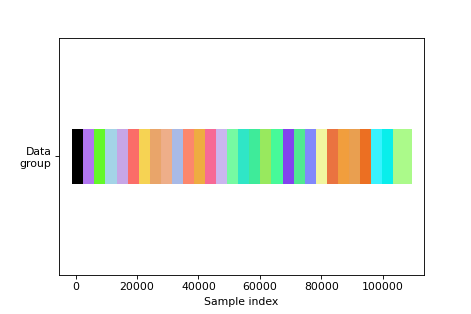

In [233]:
# Evenly spaced groups repeated once
groups = np.hstack([[ii]*group_len for ii in range(n_groups)])


def visualize_groups(classes, groups):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(range(len(groups)),  [.5] * len(groups), c=groups, marker='_',
               lw=50,
               cmap=cmap_data,
              )

    ax.set(
#         ylim=[-1, 5],
        yticks=[.5],
        yticklabels=['Data\ngroup'],
        xlabel="Sample index")

%matplotlib notebook
%matplotlib notebook
visualize_groups(y_input, groups)

In [234]:
def make_cv_indices(cv, X, y, group, lw=20, plot_pref=True):
    """Create a sample plot for indices of a cross-validation object."""

    cv_idx = list(cv.split(X=X , y=y , groups=group))
    
    n_splits = cv.n_splits
    # Generate the training/testing visualizations for each CV split
    if plot_pref:
        fig, ax = plt.subplots()

    #     for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
            # Fill in indices with the training/test groups
            indices = np.array([np.nan] * len(X))
            indices[tt] = 1
            indices[tr] = 0

            # Visualize the results
            ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                       c=indices, marker='_', lw=lw, cmap=cmap_cv,
                       vmin=-.2, vmax=1.2)

        # Plot the data classes and groups at the end
    #     ax.scatter(range(len(X)), [ii + 1.5] * len(X),
    #                c=y, marker='_', lw=lw, cmap=cmap_data)

        ax.scatter(range(len(X)), [ii + 1.5] * len(X),
                   c=group, marker='_', lw=lw, cmap=cmap_data)

        # Formatting
        yticklabels = list(range(n_splits)) + ['group']
        ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
               xlabel='Sample index', ylabel="CV iteration",
               ylim=[n_splits+1.2, -.2], xlim=[0, 108000])
        ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return cv_idx

<IPython.core.display.Javascript object>


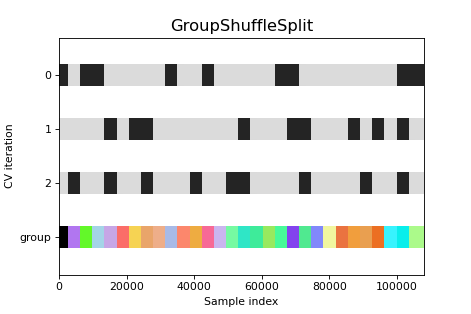

In [235]:
%matplotlib notebook
n_splits = 3
test_size = 0.3
cv = GroupShuffleSplit(n_splits, test_size=test_size)
sample_idx = np.arange(X_input.shape[0])
cv_idx = make_cv_indices(cv, sample_idx, sample_idx, groups, lw=20, plot_pref=True)

In [236]:
n_nonzero_rolls = 1

min_roll = 60*10*Fs_2p
max_roll = X.shape[0] - min_roll
rolls = np.concatenate(([0] , np.random.randint(min_roll, max_roll, n_nonzero_rolls)))
n_rolls = n_nonzero_rolls + 1

In [237]:
import cudf
import cuml
import cupy

In [243]:
X = cupy.asarray(X)
y = cupy.asarray(y)

In [249]:
# alphas = np.array([
# #     0.0001 , 
#     0.002, 0.004, 0.008,
#     0.012, 0.02 ,
#     0.04 ,
# #     0.08 , 0.15 , 0.3 ,
# #     0.6
#         ])

alphas = np.array([
    0.008
])
# l1_ratios = np.array([1 , 0.99 , 0.95 , 0.9 , 0.7 , 0.5 , 0.2 ,
# #                       0.1 , 0.01
#                      ])
l1_ratios = np.array([0])

n_alphas = len(alphas)
n_l1Ratios = len(l1_ratios)

len_train = len(cv_idx[0][0])
len_test = len(cv_idx[0][1])

# y = np.zeros((X.shape[0] , num_factors , n_rolls))
theta_FF = np.ones((X.shape[1] , num_factors , n_splits , n_rolls , n_alphas , n_l1Ratios))
R_train = np.zeros((num_factors, n_splits , n_rolls , n_alphas , n_l1Ratios))
R_test = np.zeros((num_factors,n_splits , n_rolls , n_alphas , n_l1Ratios))
y_reconstructed_FF = np.zeros((X.shape[0] , num_factors , n_splits , n_rolls , n_alphas , n_l1Ratios))
y_train_reconstructed_FF = np.zeros((len_train , num_factors , n_splits , n_rolls , n_alphas , n_l1Ratios))
y_test_reconstructed_FF = np.zeros((len_test , num_factors , n_splits , n_rolls , n_alphas , n_l1Ratios))

for iter_factor in range(num_factors):
# for iter_factor in np.array([5]):
    for iter_roll in range(n_rolls):
#         y[:, iter_factor, iter_roll] = np.roll(y_input[:,iter_factor] , rolls[iter_roll])
        y_iter = np.roll(y[:,iter_factor] , rolls[iter_roll])

    #     X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    #         X, y[:,iter_factor], test_size=0.3, random_state=0)

        for iter_cv, (idx_train , idx_test) in enumerate(cv_idx):
            X_train = X[idx_train,:]
            y_train = y_iter[idx_train]
            X_test = X[idx_test,:]
            y_test = y_iter[idx_test]
            
            for iter_alpha , alpha in enumerate(alphas):
                for iter_l1Ratio , l1_ratio in enumerate(l1_ratios):

                    ### SKLEARN regression
                    clf = sklearn.linear_model.Lasso(alpha=alpha,
                                                     fit_intercept=False,
                                                     normalize=False,
                                                     precompute=False,
                                                     copy_X=True,
                                                     max_iter=1000,
                                                     tol=0.0001,
                                                     warm_start=True,
                                                     positive=False,
                                                     random_state=None,
                                                     selection='cyclic'
                                                    )
                    
#                     clf = sklearn.linear_model.ElasticNet(alpha=alpha,
#                                                           l1_ratio=l1_ratio,
#                                                           fit_intercept=False,
#                                                           normalize=False,
#                                                           precompute=False,
#                                                           max_iter=1000,
#                                                           copy_X=True,
#                                                           tol=0.0001,
#                                                           warm_start=True,
#                                                           positive=False,
#                                                           random_state=None,
#                                                           selection='cyclic'
#                                                          )
                    
#                     clf = sklearn.linear_model.SGDRegressor(loss='squared_loss',
#                                                             penalty='elasticnet',
#                                                             alpha=0.0001,
#                                                             l1_ratio=0.15,
#                                                             fit_intercept=True,
#                                                             max_iter=1000, 
#                                                             tol=0.001,
#                                                             shuffle=True,
#                                                             verbose=0,
# #                                                             epsilon=0.1,
# #                                                             random_state=None, 
#                                                             learning_rate='invscaling', 
#                                                             eta0=0.01, 
#                                                             power_t=0.25, 
# #                                                             early_stopping=False,
# #                                                             validation_fraction=0.1, 
# #                                                             n_iter_no_change=5,
#                                                             warm_start=True,
#                                                             average=False
#                                                            )


                    clf = cuml.linear_model.Lasso(alpha=alpha,
                                                       fit_intercept=False,
                                                       normalize=False,
                                                       max_iter=1000,
                                                       tol=0.0001,
                                                       selection='cyclic',
                                                       handle=None,
                                                       output_type='numpy',
                                                       verbose=False
                                                      )
                    
                    clf.fit(X_train , y_train )
#                     theta_FF[:, iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = clf.coef_
                    theta_FF[:, iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = cupy.asnumpy(clf.coef_)


        #             theta_FF[:, iter_factor, iter_cv, iter_roll] = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

                    y_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]       = cupy.asnumpy(clf.predict(X))
                    y_train_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = cupy.asnumpy(clf.predict(X_train))
                    y_test_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]  = cupy.asnumpy(clf.predict(X_test))
                

                    R_train[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = cupy.asnumpy((np.corrcoef(y_train_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio], y_train))[1,0])
#                     print(f'factor #: {iter_factor} , Roll iter: {iter_roll} , CV repeat #: {iter_cv} , alpha val: {alpha} , l1_ratio: {l1_ratio} , train  R: {round(R_train[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio],3)} , train R^2: {round(R_train[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]**2,3)}')
                    print(f'factor #: {iter_factor} , Roll iter: {iter_roll} , CV repeat #: {iter_cv} , alpha val: {alpha} , l1_ratio: {l1_ratio} , train  R: {round(R_train[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio],3)} , train R^2: {round(R_train[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]**2,3)}')

                    R_test[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio] = cupy.asnumpy((np.corrcoef(y_test_reconstructed_FF[:,iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio], y_test))[1,0])
#                     print(f'factor #: {iter_factor} , Roll iter: {iter_roll} , CV repeat #: {iter_cv} , alpha val: {alpha} , l1_ratio: {l1_ratio} , test   R: {round(R_test[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio],3)} , test  R^2: {round(R_test[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]**2,3)} \n')
                    print(f'factor #: {iter_factor} , Roll iter: {iter_roll} , CV repeat #: {iter_cv} , alpha val: {alpha} , l1_ratio: {l1_ratio} , test   R: {round(R_test[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio],3)} , test  R^2: {round(R_test[iter_factor, iter_cv, iter_roll, iter_alpha, iter_l1Ratio]**2,3)} \n')

            gc.collect()

factor #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0 , train  R: 0.862 , train R^2: 0.742
factor #: 0 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0 , test   R: 0.858 , test  R^2: 0.736 

factor #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0 , train  R: 0.869 , train R^2: 0.755
factor #: 0 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0 , test   R: 0.826 , test  R^2: 0.682 

factor #: 0 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0 , train  R: 0.871 , train R^2: 0.758
factor #: 0 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0 , test   R: 0.822 , test  R^2: 0.676 

factor #: 0 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0 , train  R: 0.47 , train R^2: 0.221
factor #: 0 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0 , test   R: -0.007 , test  R^2: 0.0 

factor #: 0 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0 , tra

factor #: 6 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0 , train  R: 0.773 , train R^2: 0.598
factor #: 6 , Roll iter: 0 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0 , test   R: 0.786 , test  R^2: 0.619 

factor #: 6 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0 , train  R: 0.783 , train R^2: 0.613
factor #: 6 , Roll iter: 0 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0 , test   R: 0.772 , test  R^2: 0.595 

factor #: 6 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0 , train  R: 0.785 , train R^2: 0.616
factor #: 6 , Roll iter: 0 , CV repeat #: 2 , alpha val: 0.008 , l1_ratio: 0 , test   R: 0.765 , test  R^2: 0.585 

factor #: 6 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0 , train  R: 0.395 , train R^2: 0.156
factor #: 6 , Roll iter: 1 , CV repeat #: 0 , alpha val: 0.008 , l1_ratio: 0 , test   R: -0.028 , test  R^2: 0.001 

factor #: 6 , Roll iter: 1 , CV repeat #: 1 , alpha val: 0.008 , l1_ratio: 0 , 

In [82]:
# save regression outputs

cv_params = {
                    "rolls": rolls,
                    "group_len": group_len,
                    "groups": groups,
                    "n_groups": n_groups,
                    "n_splits": n_splits,
                    "test_size": test_size,
                    "min_roll": min_roll,
                    "cv_idx": cv_idx
}

regression_run = {
                    "alphas": alphas,
                    "l1_ratios": l1_ratios,
                    "IsCell_ROIClassifier": IsCell_ROIClassifier,
                    "X_input": X_input,
                    "y_input": y_input,
                    "theta_FF":theta_FF,
                    "y_reconstructed_FF": y_reconstructed_FF,
                    "y_train_reconstructed_FF": y_train_reconstructed_FF,
                    "y_test_reconstructed_FF": y_test_reconstructed_FF,
                    "R_train": R_train,
                    "R_test": R_test,
                    "cv_params": cv_params,
                    "linear_regression_model": clf
}


In [83]:
from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_save = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/postHoc_analysis')
fileName_save = 'regression_run_'
fileSuffix_save = '.npy'
path_save = dir_save / (fileName_save + today + fileSuffix_save)

print(f'Saving to: {path_save}')
np.save(path_save , regression_run)

Saving to: /media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/postHoc_analysis/regression_run_20210504.npy


In [86]:
from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_load = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210417/postHoc_analysis')
fileName_load = 'regression_run_20210503'
fileSuffix_load = '.npy'
path_load = dir_load / (fileName_load + fileSuffix_load)
# path_load = dir_load / fileName_load

regression_run = np.load(path_load , allow_pickle=True)

alphas = regression_run[()]['alphas']
l1_ratios = regression_run[()]['l1_ratios']
IsCell_ROIClassifier = regression_run[()]['IsCell_ROIClassifier']
l1_ratios = regression_run[()]['l1_ratios']
X_input = regression_run[()]['X_input']
y_input = regression_run[()]['y_input']
theta_FF = regression_run[()]['theta_FF']
y_reconstructed_FF = regression_run[()]['y_reconstructed_FF']
y_train_reconstructed_FF = regression_run[()]['y_train_reconstructed_FF']
y_test_reconstructed_FF = regression_run[()]['y_test_reconstructed_FF']
R_train = regression_run[()]['R_train']
R_test = regression_run[()]['R_test']
cv_params = regression_run[()]['cv_params']
clf = regression_run[()]['linear_regression_model']

rolls = cv_params['rolls']
group_len = cv_params['group_len']
groups = cv_params['groups']
n_groups = cv_params['n_groups']
n_splits = cv_params['n_splits']
test_size = cv_params['test_size']
min_roll = cv_params['min_roll']
cv_idx = cv_params['cv_idx']

<IPython.core.display.Javascript object>


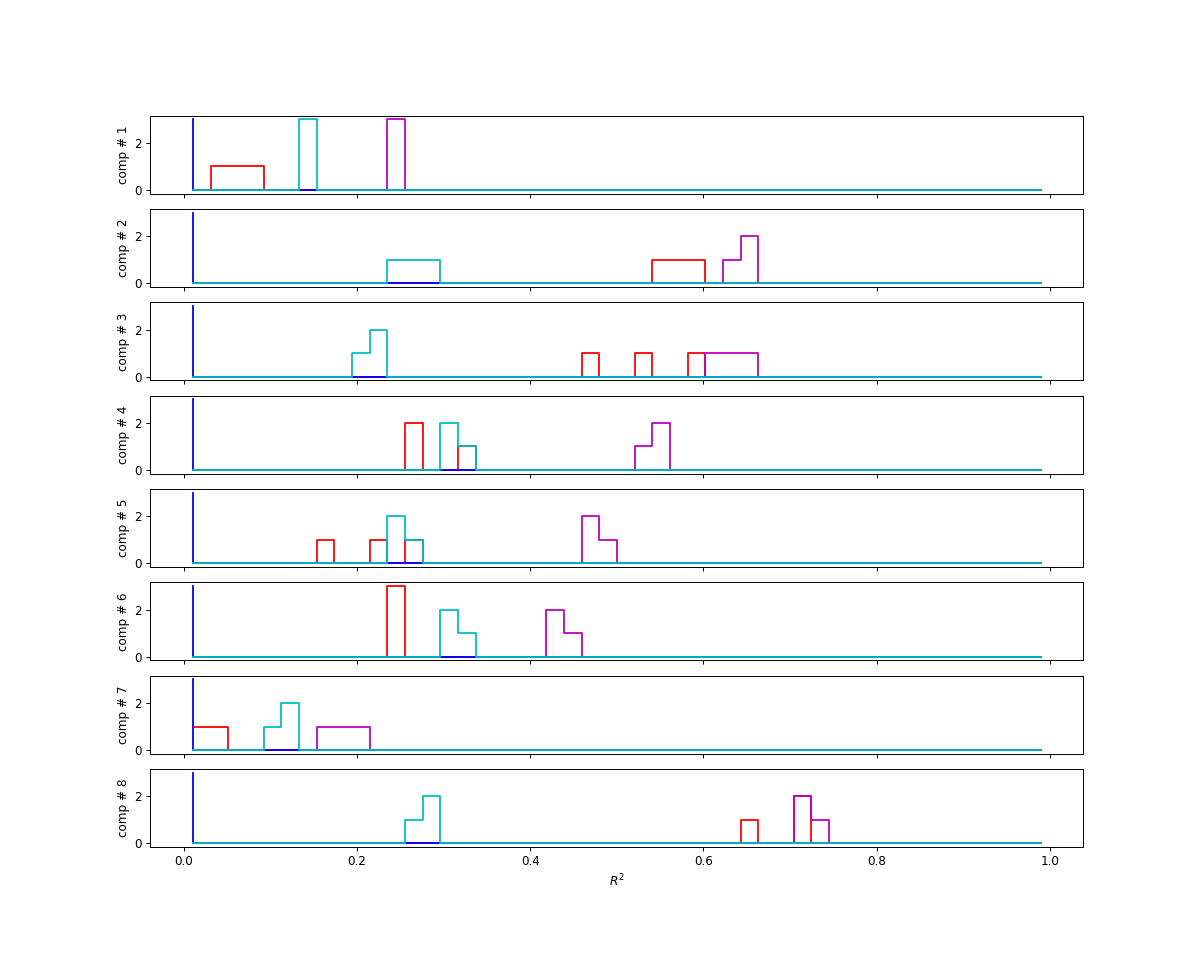

In [84]:
alf = 0
l1R = 0

n_bins = 50
n_rolls = len(rolls)

%matplotlib notebook
fig, axs = plt.subplots(num_factors, sharex=True, sharey=True)
comps_toUse = np.arange(num_factors)
for i_comp, comp in enumerate(comps_toUse):

    for i_shuf,vals in enumerate(np.arange(n_rolls)):
#         data = R_test[comp,:,i_shuf,alf,l1R]**2
        data = R_test[comp,:,i_shuf,alf,l1R]**2
        bins = np.linspace(0,1,n_bins)

        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        if i_shuf==0:
            axs[i_comp].step(edges_centers , counts , 'r')
        else:
            axs[i_comp].step(edges_centers , counts , 'b')
        
#         data = R_train[comp,:,i_shuf,alf,l1R]**2
        data = R_train[comp,:,i_shuf,alf,l1R]**2
        bins = np.linspace(0,1,n_bins)

        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2
        
        if i_shuf==0:
            axs[i_comp].step(edges_centers , counts , 'm')
        else:
            axs[i_comp].step(edges_centers , counts , 'c')
        
        plt.xlabel('$R^2$')
        axs[i_comp].set_ylabel(f'comp # {comp+1}')
#         axs.subplot(sharey = ax1)
#         plt.legend(('test','train','test shuffle','train shuffle'))


<IPython.core.display.Javascript object>


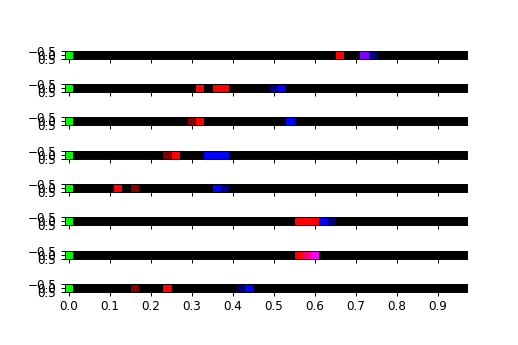

In [51]:
n_alphas = R_test.shape[3]
n_fac = R_test.shape[0]

fig, axs = plt.subplots(n_fac, sharex=True, sharey=False)

for i_fac in range(n_fac):

    im = np.zeros((n_alphas, len(edges_centers),3))
    for alf in range(n_alphas):
        data = R_test[i_fac,:,0,alf,0]**2
        bins = np.linspace(0,1,n_bins)
        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        im[alf,:,0] = counts

        data = R_test[i_fac,:,1,alf,0]**2
        bins = np.linspace(0,1,n_bins)
        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        im[alf,:,1] = counts
        
        data = R_train[i_fac,:,0,alf,0]**2
        bins = np.linspace(0,1,n_bins)
        counts , edges = numpy.histogram(data, bins)
        edges_centers = (edges[:-1] + edges[1:]) / 2

        im[alf,:,2] = counts

    im_norm = np.zeros((n_alphas, len(edges_centers),3))
    im_norm[:,:,0] = im[:,:,0] / np.max(im[:,:,0])
    im_norm[:,:,1] = im[:,:,1] / np.max(im[:,:,1])
    im_norm[:,:,2] = im[:,:,2] / np.max(im[:,:,2])
    axs[i_fac].imshow(im_norm)
    
    ticks_toUse = np.arange(0,len(edges_centers) , 5)
    axs[i_fac].set_xticks(ticks_toUse)
    axs[i_fac].set_xticklabels(np.round(edges_centers[ticks_toUse],1))

<IPython.core.display.Javascript object>


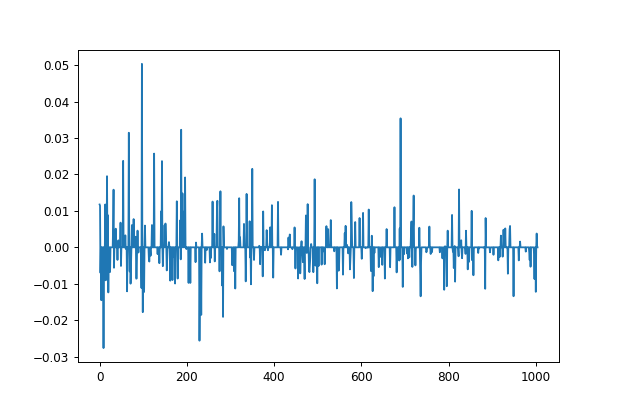

286


In [346]:
%matplotlib notebook

factors_toShow = np.array([1]) # 1-indexed
plt.figure()
for ii in factors_toShow:
    
    weights = theta_FF[1:,ii-1,0,0,0,0]
    if ii==2:
        weights=weights*-1
    print(np.sum(weights!=0))

    plt.plot(weights)
#     plt.plot(scipy.signal.savgol_filter(weights , 101 , 3));

In [356]:
y_reconstructed_FF.shape

(108000, 8, 20, 2, 1, 1)

<IPython.core.display.Javascript object>


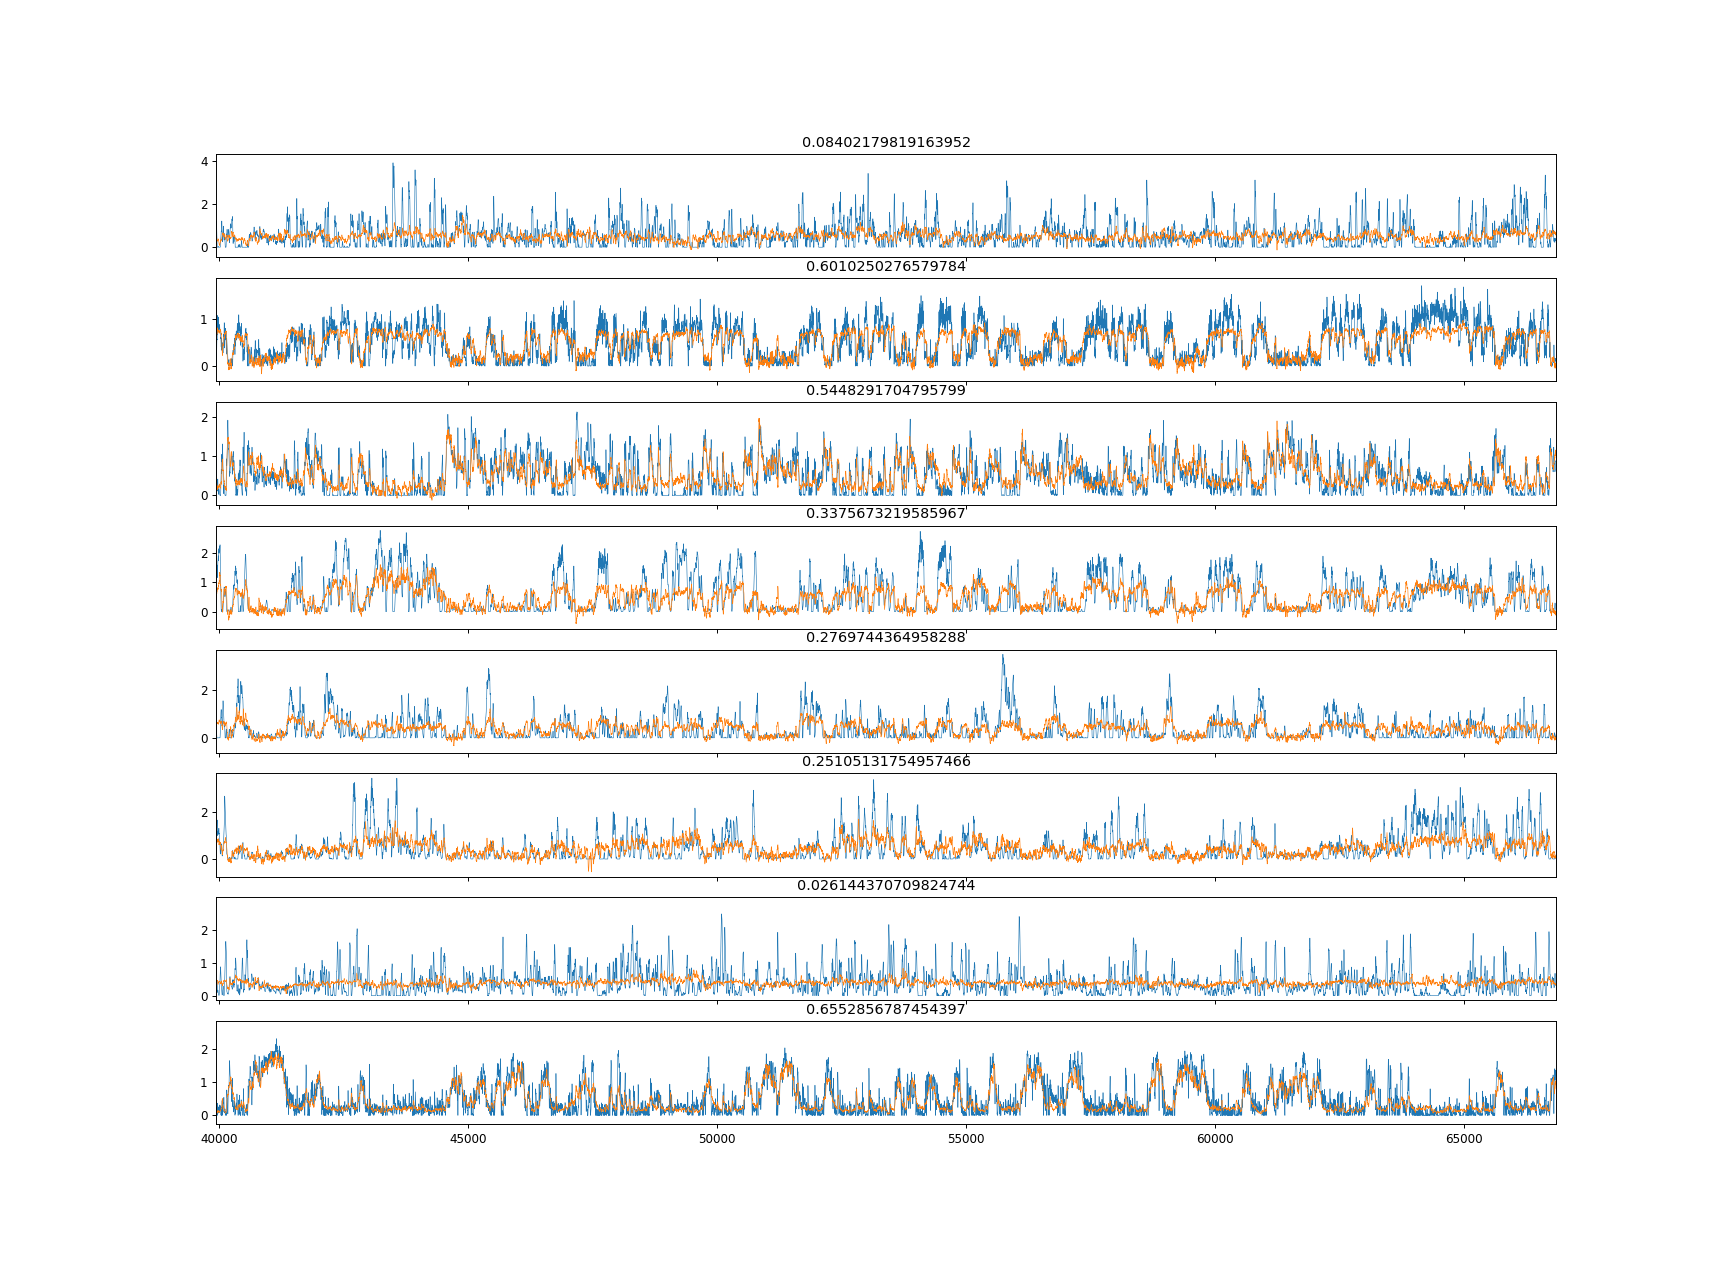

<IPython.core.display.Javascript object>


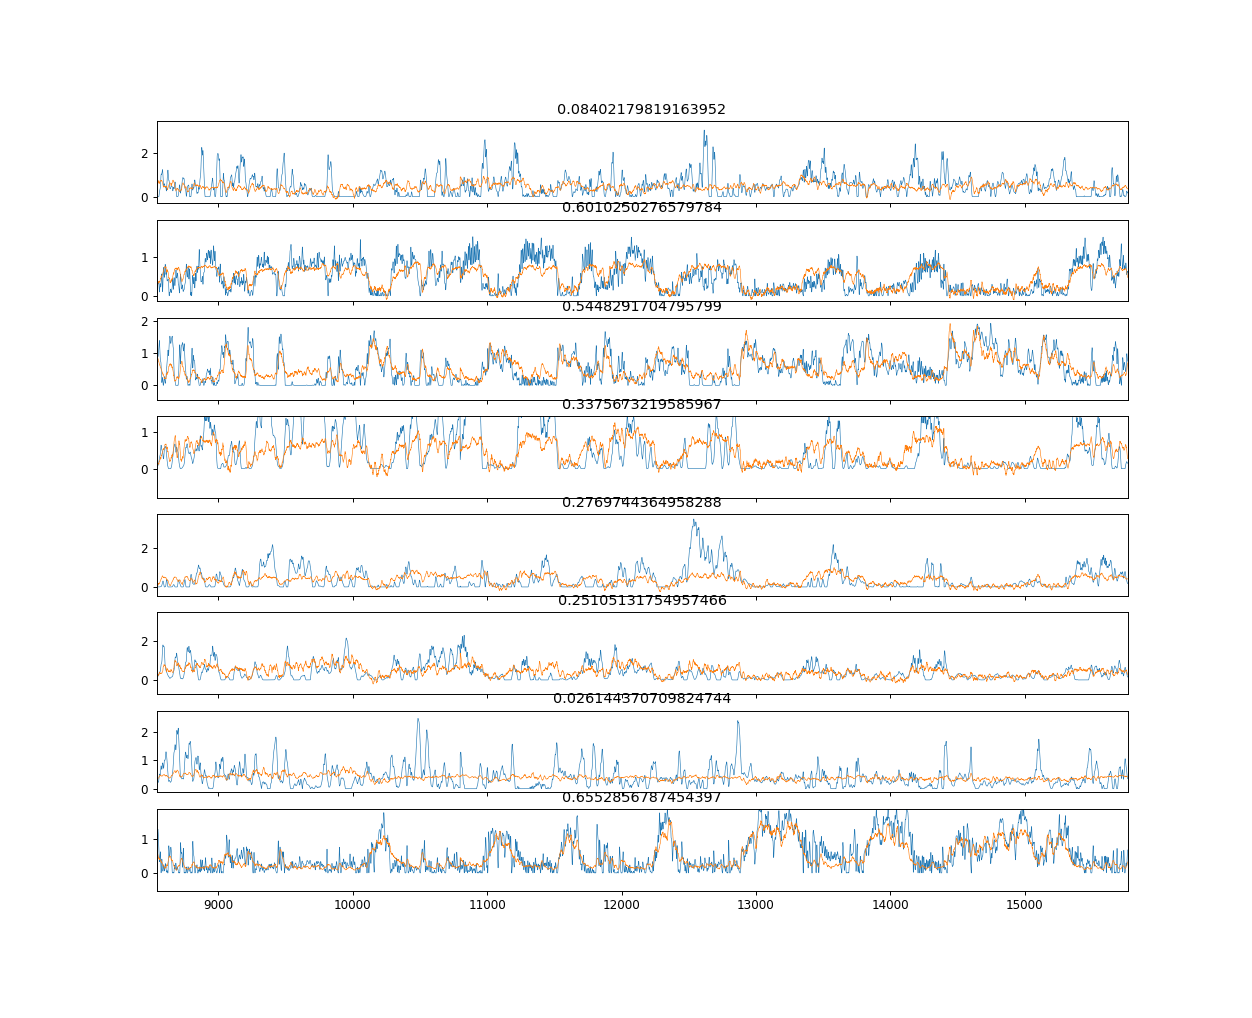

In [399]:
# full time series
fig, axs = plt.subplots(num_factors, 1, sharex=True, sharey=False)
for iter_factor in range(num_factors):
    axs[iter_factor].plot(y_input[:,iter_factor] , linewidth=0.5)
    axs[iter_factor].plot(y_reconstructed_FF[:,iter_factor,0,0,0,0] , linewidth=0.5)
    axs[iter_factor].set_title(R_test[iter_factor,0,0,0,0]**2)
    
# held out test data
fig, axs = plt.subplots(num_factors, 1, sharex=True, sharey=False)
for iter_factor in range(num_factors):
    cv_idx_tmp = cv_idx[0]
    axs[iter_factor].plot(y_input[cv_idx_tmp[1],iter_factor] , linewidth=0.5)
    axs[iter_factor].plot(y_reconstructed_FF[cv_idx_tmp[1],iter_factor,0,0,0,0] , linewidth=0.5)
    axs[iter_factor].set_title(R_test[iter_factor,0,0,0,0]**2)

In [15]:
# compare NMF(neural data) to FR(behavioral data)_temporal factors



In [23]:
manual_selection_vars = np.load('/media/rich/bigSSD RH/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/analysis_lastNight/manual_selection_vars.npy' , allow_pickle=True)

In [27]:
manual_selection_vars[()].keys()

dict_keys(['toInclude_preExclusion', 'toExclude_manuallyClicked', 'predictions', 'output_activations', 'prob', 'toInclude_final', 'spatial_footprints_centered_toInclude', 'spatial_footprints_centered_crop_toInclude'])

In [31]:
IsCell_ROIClassifier2 = np.zeros(len(IsCell_ROIClassifier)+1)
IsCell_ROIClassifier2[:len(IsCell_ROIClassifier)] = IsCell_ROIClassifier
IsCell_ROIClassifier2.shape

(4870,)

In [32]:
IsCell_ROIClassifier = copy.deepcopy(IsCell_ROIClassifier2)

In [93]:
# import sklearn.linear_model
# from catboost import CatBoostRegressor
from tqdm import tqdm

# num_factors = temporalFactors_s2pInd.shape[1]

X_input = scipy.signal.savgol_filter( spks[IsCell_ROIClassifier==True,:].T , 31 , 3 , axis=0)
X_input[X_input<0] = 0
# X_input /= np.std(X_input, axis=0)
# X_input = scipy.stats.zscore(X_input , axis=0)

# y_input = temporalFactors_s2pInd[:,:]

In [94]:
X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
# y = copy.deepcopy(y_input)

<IPython.core.display.Javascript object>


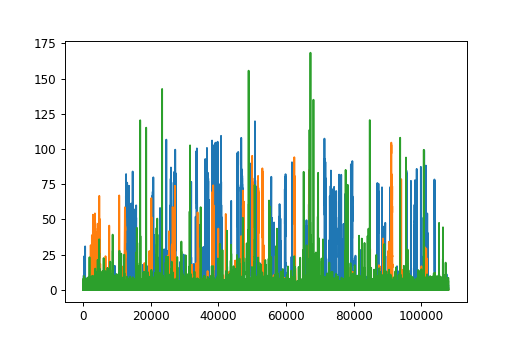

In [95]:
plt.figure()
plt.plot(X_input[:,np.array([0,1,800])])

In [191]:
fac_neuron2 = copy.deepcopy(fac_neuron)
fac_temp2 = copy.deepcopy(fac_temp)
rec_err2 = copy.deepcopy(rec_err)

In [96]:
import tensorly as tl
import tensorly.decomposition
import torch

In [97]:
tl.set_backend('pytorch')
cuda_device_number = torch.cuda.current_device()
cuda_device_number
X_input_tensor = tl.tensor(X_input, dtype=tl.float32, device=0, requires_grad=False)

In [98]:
from tqdm.notebook import trange, tqdm
n_repeats = 1
# ranks = np.array([15,16,17,18,19,20,21,22])
# ranks = np.arange(30)+1
ranks = np.array([8])

n_ranks = len(ranks)
n_neurons = X_input.shape[1]
n_timepoints = X_input.shape[0]

fac_neuron = list(np.zeros(n_ranks))
fac_temp = list(np.zeros(n_ranks))
rec_err = list(np.zeros(n_ranks))
for i_rank, rank in enumerate(tqdm(ranks)):
    fac_neuron[i_rank] = np.zeros((n_neurons , rank , n_repeats))
    fac_temp[i_rank] = np.zeros((n_timepoints , rank , n_repeats))
    rec_err[i_rank] = np.zeros((n_repeats))
    for i_rep in trange(n_repeats):
        model = sklearn.decomposition.NMF(n_components=rank,
                                          init='random',
                                          solver='cd',
                                          beta_loss='frobenius',
                                          tol=0.000001,
                                          max_iter=10000,
                                          random_state=None,
                                          alpha=0.0,
                                          l1_ratio=0.0,
                                          verbose=False,
                                          shuffle=False,
                                          regularization='both'
                                         )

        fac_neuron[i_rank][:,:, i_rep] = model.fit_transform(X_input.T)
        fac_temp[i_rank][:,:, i_rep] = model.components_.T
        rec_err[i_rank][i_rep] = model.reconstruction_err_

#         k_tensor, recErr = tl.decomposition.non_negative_parafac_hals(
#                                                                         X_input_tensor,
#                                                                         rank,
#                                                                         n_iter_max=1000,
#                                                                         init='random',
#                                                                         svd='numpy_svd',
#                                                                         tol=1e-07,
#                                                                         sparsity_coefficients=None,
#                                                                         fixed_modes=None,
#                                                                         exact=False,
#                                                                         verbose=False,
#                                                                         return_errors=True,
#                                                                         cvg_criterion='abs_rec_error'
#                                                                         )
#
#         fac_neuron[i_rank][:,:, i_rep] = k_tensor[1][1].cpu()
#         fac_temp[i_rank][:,:, i_rep] = k_tensor[1][0].cpu()
#         rec_err[i_rank][i_rep] = recErr[-1].cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [100]:
NMF_outputs = {
    "fac_neuron": fac_neuron,
    "fac_temp": fac_temp,
    "rec_err": rec_err,
    "ranks": ranks,
}

from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_save = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210417/postHoc_analysis')
fileName_save = 'NMF_outputs'
fileSuffix_save = '.npy'
path_save = dir_save / (fileName_save + today + fileSuffix_save)

print(f'Saving to: {path_save}')
np.save(path_save , NMF_outputs)

Saving to: /media/rich/bigSSD RH/analysis_data/mouse 2_6/20210417/postHoc_analysis/NMF_outputs20210504.npy


In [34]:
from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_load = Path('/media/rich/bigSSD RH/res2p/scanimage data/round 5 experiments/mouse 2_6/20210417/postHoc_analysis')
fileName_load = 'NMF_outputs'
fileSuffix_load = '.npy'
path_load = dir_load / (fileName_load + today + fileSuffix_load)
# path_load = dir_load / fileName_load

NMF_outputs = np.load(path_load , allow_pickle=True)

fac_neuron = NMF_outputs[()]['fac_neuron']
fac_temp = NMF_outputs[()]['fac_temp']
rec_err = NMF_outputs[()]['rec_err']
ranks = NMF_outputs[()]['ranks']

<IPython.core.display.Javascript object>


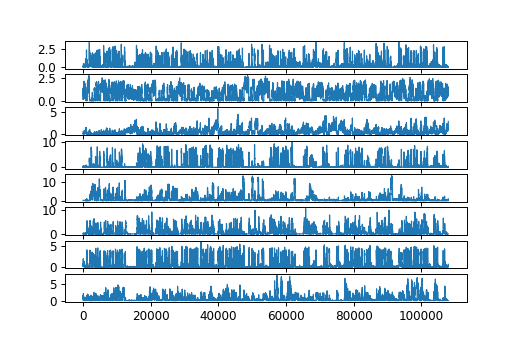

<IPython.core.display.Javascript object>


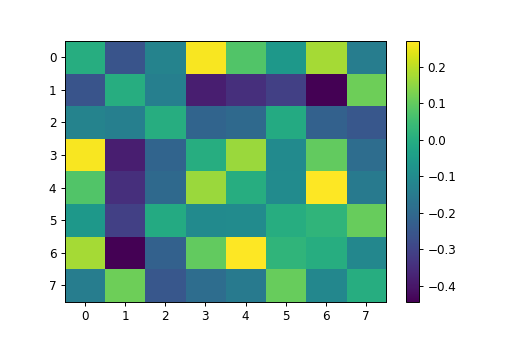

<IPython.core.display.Javascript object>


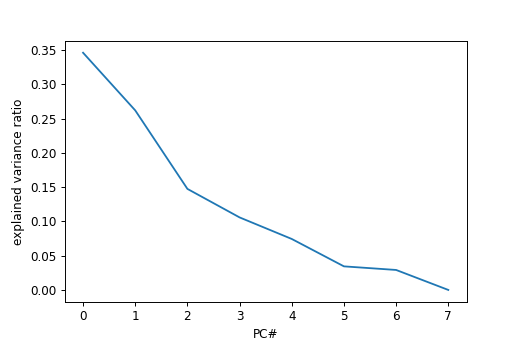

Text(0, 0.5, 'explained variance ratio')

In [101]:
%matplotlib notebook
repeat_toPlot = 0 # 0-indexed
rank_toPlot = 8 # 

rank_idx_toPlot = np.where(ranks==rank_toPlot)[0][0]
n_components = rank_toPlot
fig, axs = plt.subplots(n_components , sharex=True , sharey=False)
for ii in range(n_components):
    axs[ii].plot(fac_temp[rank_idx_toPlot][:,ii,repeat_toPlot] , linewidth=1)

plt.figure()
plt.imshow(np.corrcoef(fac_temp[rank_idx_toPlot][:,:,repeat_toPlot].T) - np.eye(n_components),aspect='auto')
plt.colorbar()

input_dimRed = fac_temp[rank_idx_toPlot][:,:,repeat_toPlot]
n_components = input_dimRed.shape[1]
pca = sk.decomposition.PCA(n_components=n_components)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
pca.fit(np.single(input_dimRed).transpose())
output_PCA = pca.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

output_PCA.shape
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('PC#')
plt.ylabel('explained variance ratio')

In [219]:
def pairwise_similarity(vector_set1 , vector_set2 , method):
    from numpy.linalg import norm
    from scipy.stats import zscore
    
    if method=='pearson':
        output = (zscore(vector_set1, axis=0).T @ zscore(vector_set2, axis=0)) / ((vector_set1.shape[0] + vector_set2.shape[0])/2)
    if method=='R^2':
        output = ( (zscore(vector_set1, axis=0).T @ zscore(vector_set2, axis=0)) / ((vector_set1.shape[0] + vector_set2.shape[0])/2) )**2
    if method=='cosine_similarity':    
        output = (vector_set1 / (np.expand_dims(norm(vector_set1 , axis=0) , axis=0))).T  @ (vector_set2  / np.expand_dims(norm(vector_set2 , axis=0) , axis=0))
    return output

def similarity_2(mat1 , mat2 , method):
    import numpy as np
    '''
    This function compares the representations of two sets of vectors (columns of mat1 and columns of mat2).
    We assume that the vectors in mat1 and mat2 are similar up to a permutation.
    We therefore find the 'best' permutation that maximizes the similarity between the sets of vectors
    
    Args:
        mat1 (np.ndarray): a 2D array where the columns are vectors we wish to match with mat2
        mat2 (np.ndarray): a 2D array where the columns are vectors we wish to match with mat1
        method (string)  : defines method of calculating pairwise similarity between vectors
        
    Returns:
        sim_avg (double)    : the average similarity between matched vectors. Units depend on method
        sim_matched (double): the similarity between each pair of matched vectors.
        ind1 (int)          : indices of vectors in mat1 matched to ind2 in mat2 (usually just sequential for ind1)
        ind2 (int)          : indices of vectors in mat2 matched to ind1 in mat1
    '''
    corr = mat1.T @ mat2
    ind1 , ind2 = scipy.optimize.linear_sum_assignment(corr, maximize=True)
    sim_matched = np.zeros(len(ind1))
    for ii in range(len(ind1)):
        if method=='pearson':
            sim_matched[ii] = np.corrcoef(mat1[:,ind1[ii]] , mat2[:,ind2[ii]])[0][1]
        if method=='R^2':
            sim_matched[ii] = (np.corrcoef(mat1[:,ind1[ii]] , mat2[:,ind2[ii]])[0][1])**2
        if method=='cosine_similarity':
            sim_matched[ii] = pairwise_similarity( mat1[:,ind1[ii]] , mat2[:,ind2[ii]] , 'cosine_similarity')

    sim_avg = np.mean(sim_matched)
    return sim_avg , sim_matched , ind1 , ind2

def self_similarity_pairwise(mat_set , method):
    '''
    This function compares sets of matrices using the similarity_2 function.
    We assume that the vectors within the matrices are similar up to a permutation.
    We therefore find the 'best' permutation that maximizes the similarity between the sets of vectors within each matrix
    
    Args:
        mat_set (np.ndarray): a 3D array where the columns are vectors we wish to match with the columns of 
        method (string)     : defines method of calculating pairwise similarity between vectors

    Returns:
        same as similarity_2, but over each combo
        combos: combinations of pairwise comparisons
    '''
    
    import itertools

    n_repeats = mat_set.shape[2]
    n_components = mat_set.shape[1]

    combos = np.array(list(itertools.combinations(np.arange(n_repeats),2)))
    n_combos = len(combos)

    corr_avg = np.zeros((n_combos))
    corr_matched = np.zeros((n_components , n_combos))
    ind1 = np.zeros((n_components , n_combos))
    ind2 = np.zeros((n_components , n_combos))
    for i_combo , combo in enumerate(combos):
        corr_avg[i_combo] , corr_matched[:,i_combo] , ind1[:,i_combo] , ind2[:,i_combo]  =  similarity_2(mat_set[:,:,combo[0]]  ,  mat_set[:,:,combo[1]] , method)
    # print(corr_avg)
    return corr_avg, corr_matched, ind1, ind2, combos

In [ ]:
n_ranks = len(ranks)

corr_avg = list(np.zeros(n_ranks))
corr_matched = list(np.zeros(n_ranks))
ind1 = list(np.zeros(n_ranks))
ind2 = list(np.zeros(n_ranks))
combos = list(np.zeros(n_ranks))
corr_avg_mean = np.zeros(n_ranks)
corr_avg_std = np.zeros(n_ranks)


for i_rank, rank in enumerate(tqdm(ranks)):
    corr_avg[i_rank], corr_matched[i_rank], ind1[i_rank], ind2[i_rank], combos[i_rank] = self_similarity_pairwise(fac_temp[i_rank] , 'pearson')
    corr_avg_mean[i_rank] = np.mean(corr_avg[i_rank])
    corr_avg_std[i_rank] = np.std(corr_avg[i_rank])
    

In [64]:
rec_err_mean = np.zeros(n_ranks)
rec_err_std = np.zeros(n_ranks)
for i_rank, rank in enumerate(ranks):
    rec_err_mean[i_rank] = np.mean(rec_err[i_rank])
    rec_err_std[i_rank] = np.std(rec_err[i_rank])

<IPython.core.display.Javascript object>


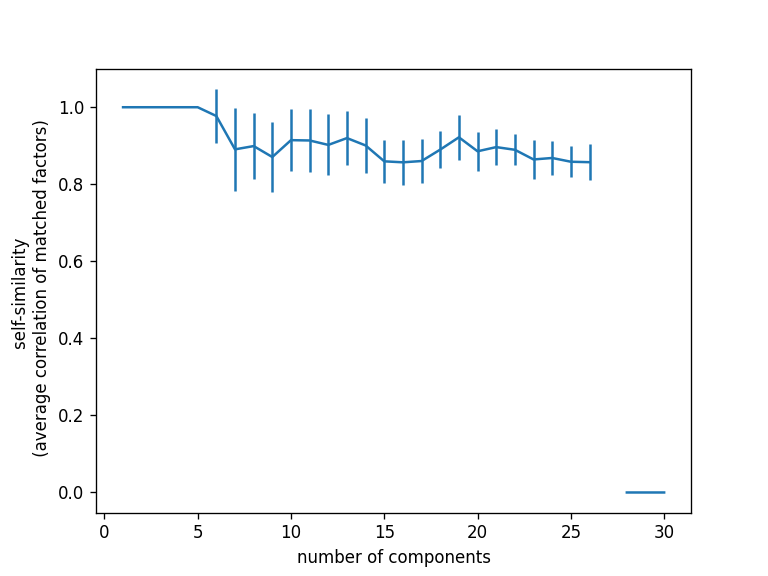

<IPython.core.display.Javascript object>


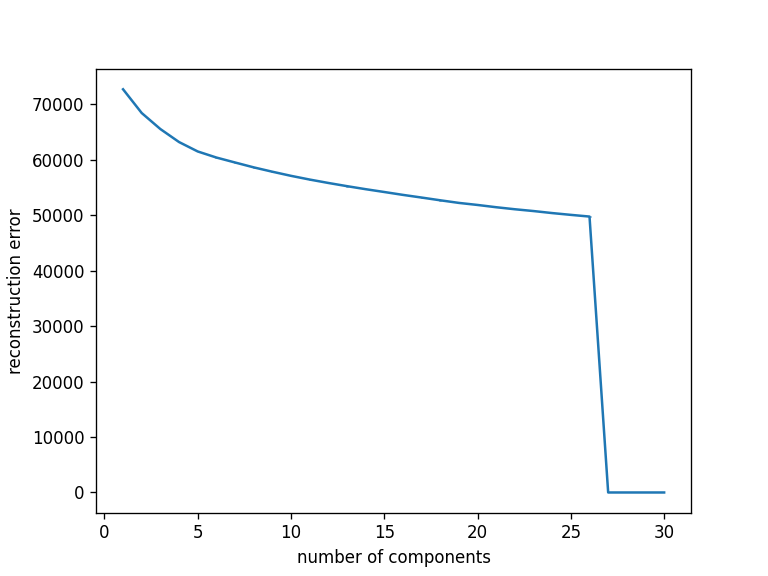

Text(0, 0.5, 'reconstruction error')

In [65]:
plt.figure()
# plt.plot(np.mean(corr_avg, axis=1))
plt.errorbar(np.arange(n_ranks)+1,
             corr_avg_mean,
             yerr=corr_avg_std
            )
plt.xlabel('number of components')
plt.ylabel('self-similarity \n (average correlation of matched factors)')

plt.figure()
# plt.plot(np.mean(corr_avg, axis=1))
plt.errorbar(np.arange(n_ranks)+1, rec_err_mean, yerr=rec_err_std)
plt.xlabel('number of components')
plt.ylabel('reconstruction error')

In [66]:
all_comparisons = {
    "corr_avg": corr_avg,
    "corr_matched": corr_matched,
    "ind1": ind1,
    "ind2": ind2,
    "combos": combos,
}
summary_stats = {
    "rec_err_mean": rec_err_mean,
    "rec_err_std": rec_err_std,
}

alignment_outputs = {
    "all_comparisons": all_comparisons,
    "summary_stats": summary_stats,
}

from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_save = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/postHoc_analysis')
fileName_save = 'alignment_outputs'
fileSuffix_save = '.npy'
path_save = dir_save / (fileName_save + today + fileSuffix_save)

print(f'Saving to: {path_save}')
np.save(path_save , alignment_outputs)

Saving to: /media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/postHoc_analysis/alignment_outputs20210503.npy


In [36]:
from datetime import date
from pathlib import Path

today = date.today().strftime("%Y%m%d")

dir_load = Path('/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409/postHoc_analysis')
fileName_load = 'alignment_outputs'
fileSuffix_load = '.npy'
path_load = dir_load / (fileName_load + today + fileSuffix_load)
# path_load = dir_load / fileName_load

alignment_outputs = np.load(path_load , allow_pickle=True)

alignment_outputs[()]['all_comparisons']['corr_avg']

corr_avg = alignment_outputs[()]['all_comparisons']['corr_avg']
corr_matched = alignment_outputs[()]['all_comparisons']['corr_matched']
ind1 = alignment_outputs[()]['all_comparisons']['ind1']
ind2 = alignment_outputs[()]['all_comparisons']['ind2']
combos = alignment_outputs[()]['all_comparisons']['combos']

rec_err_mean = alignment_outputs[()]['summary_stats']['rec_err_mean']
rec_err_std = alignment_outputs[()]['summary_stats']['rec_err_std']

In [32]:
# figure out which factors to use

In [35]:
fac_rank_toUse = 8 # actual value of rank
fac_repeat_toUse = 1 # 1-indexed repeat number

fac_rank_idx_toUse = np.where(ranks==fac_rank_toUse)[0][0]
fac_repeat_idx_toUse = fac_repeat_toUse-1

print(f' using model with rank = {fac_rank_toUse}, corresponding to rank index: {fac_rank_idx_toUse}, \n using repeat number: {fac_repeat_toUse}')\

fac_temp_toUse = fac_temp[fac_rank_idx_toUse][:,:,fac_repeat_idx_toUse]
fac_neuron_toUse = fac_neuron[fac_rank_idx_toUse][:,:,fac_repeat_idx_toUse]

 using model with rank = 8, corresponding to rank index: 0, 
 using repeat number: 1


Text(0.5, 0, 'aligned factor pair #')

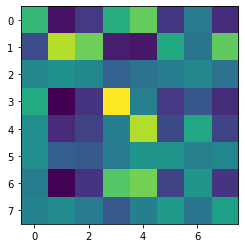

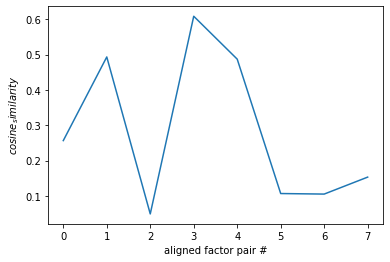

In [218]:
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
### correlate neural factors with behavioral factors

## first align the two sets of factors

# start with a cross-covariance matrix

method = 'cosine_similarity'

# vector_set1 = copy.deepcopy(fac_temp_toUse)
vector_set1 = copy.deepcopy(zscore(fac_temp_toUse,axis=0))
vector_set2 = copy.deepcopy(zscore(temporalFactors_s2pInd,axis=0))

xcorr_avg , xcorr_matched , xind1 , xind2  =  similarity_2(vector_set1  ,  vector_set2 , method)

sim_mat_aligned = pairwise_similarity(vector_set1[:,xind1] , vector_set2[:,xind2] , method)
aligned_diag = np.diag(sim_mat_aligned)
plt.figure()
plt.imshow(sim_mat_aligned)
plt.colorbar

plt.figure()
plt.plot(xcorr_matched)
plt.ylabel(f'${method}$')
plt.xlabel('aligned factor pair #')

<IPython.core.display.Javascript object>


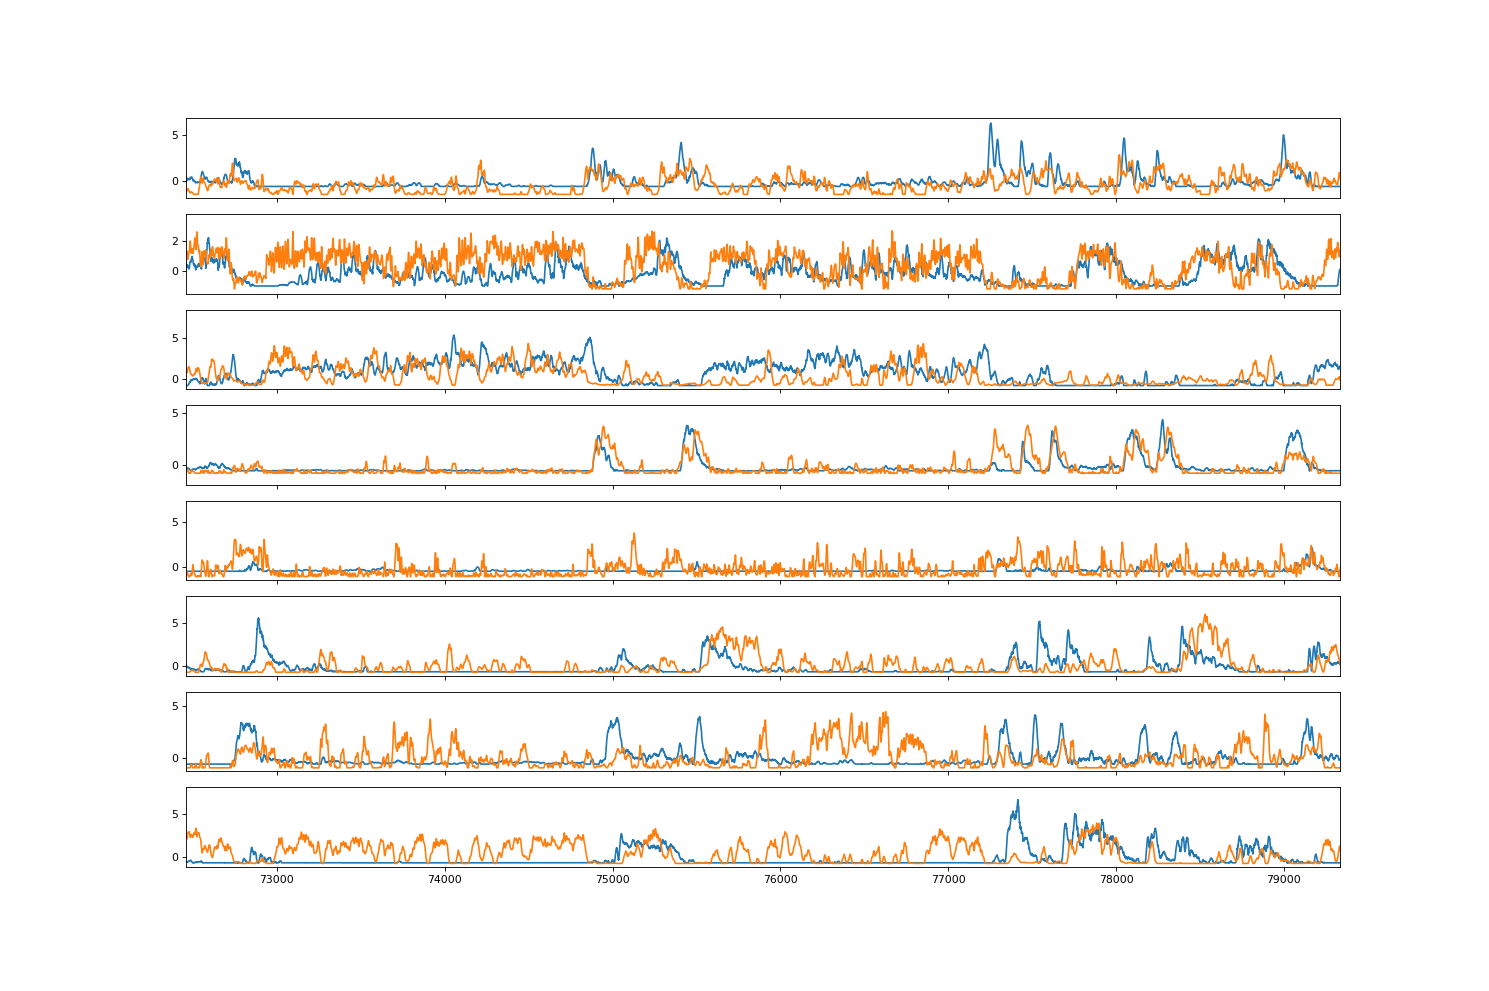

In [224]:
%matplotlib notebook

fig , axs = plt.subplots(vector_set1.shape[1] , sharex=True)
for ii in range(len(axs)):
    axs[ii].plot(vector_set1[:,xind1[ii]])
    axs[ii].plot(vector_set2[:,xind2[ii]])

In [107]:
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

cca = CCA(n_components=vector_set2.shape[1])
X_cc, Y_cc = cca.fit_transform(vector_set1, vector_set2)

In [108]:
pca = PCA(n_components=vector_set2.shape[1])
X_pc = pca.fit_transform(vector_set1)
X_pc_scree = pca.explained_variance_ratio_
Y_pc = pca.fit_transform(vector_set2)
Y_pc_scree = pca.explained_variance_ratio_

In [109]:
xcorr_mat_aligned = make_xcorrMat(X_cc , Y_cc)
R2_aligned_diag = np.diag(xcorr_mat_aligned)**2

Text(0.5, 0, 'component number')

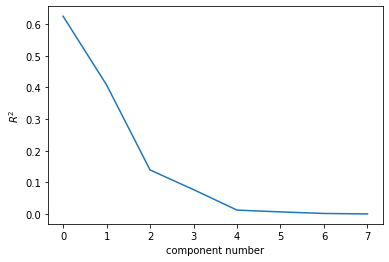

In [111]:
plt.figure()
plt.plot(R2_aligned_diag)
# plt.plot(X_pc_scree)
# plt.plot(Y_pc_scree)
plt.ylabel('$R^2$')
plt.xlabel('component number')

In [66]:
np.corrcoef(scipy.signal.savgol_filter(np.diff(X_cc[:,0]) , 31,3) , -scipy.signal.savgol_filter(np.diff(X_cc[:,1]) , 31,3))[0,1]**2

5.952432863288455e-05

<IPython.core.display.Javascript object>


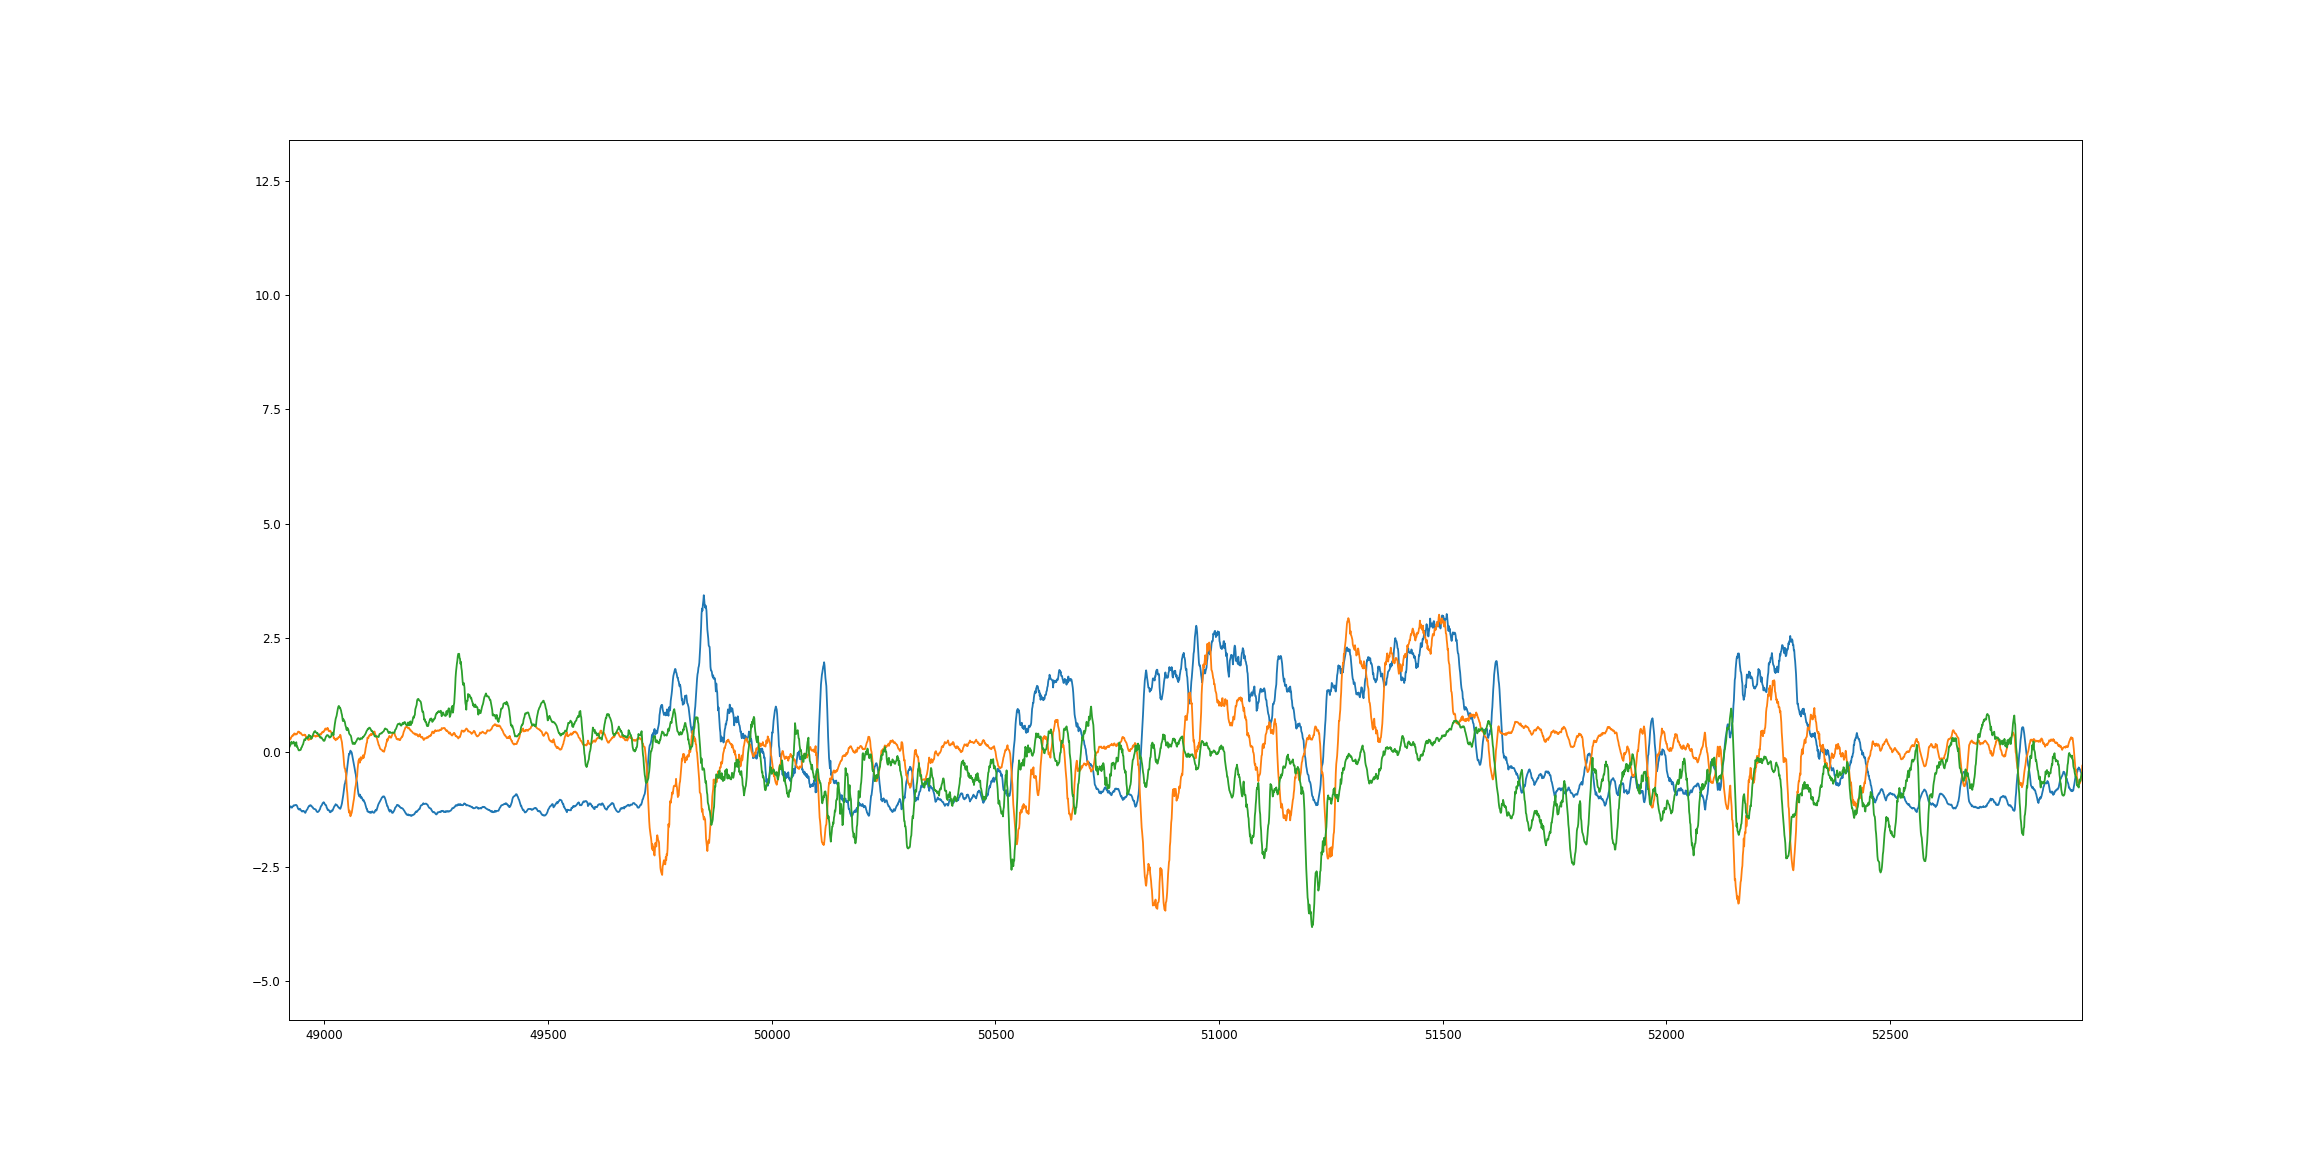

In [86]:
%matplotlib notebook
plt.figure()
plt.plot(X_cc[:,:3])
# plt.plot(scipy.signal.savgol_filter(np.diff(X_cc[:,0]) , 31,3))
# plt.plot(-scipy.signal.savgol_filter(np.diff(X_cc[:,1]) , 31,3))
# plt.plot(Y_c[:,0])
# plt.plot(-X_pc[:,1]/30)
# plt.plot(-Y_pc[:,0])


treadmill, train R: 0.8822762507831636
treadmill, test  R: 0.8772212840377442
R^2: 0.7695171811688287


<IPython.core.display.Javascript object>


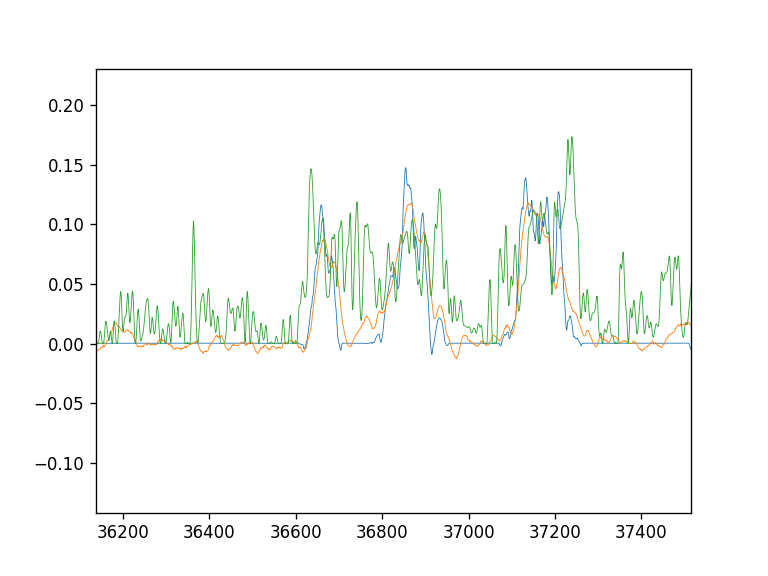

In [61]:
## Correlate to treadmill signal

idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
# idx_nonRunning[:20000] = 0
# idx_nonRunning[60000:75000] = 0

X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
y_input = scipy.signal.savgol_filter( ws_treadmill_S2pInd , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')
print(f'R^2: {R**2}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)
plt.plot(temporalFactors_s2pInd[:,7]/10 , linewidth = 0.5)

treadmill, train R: 0.8471622646934773
treadmill, test  R: 0.8401484750669375


<IPython.core.display.Javascript object>


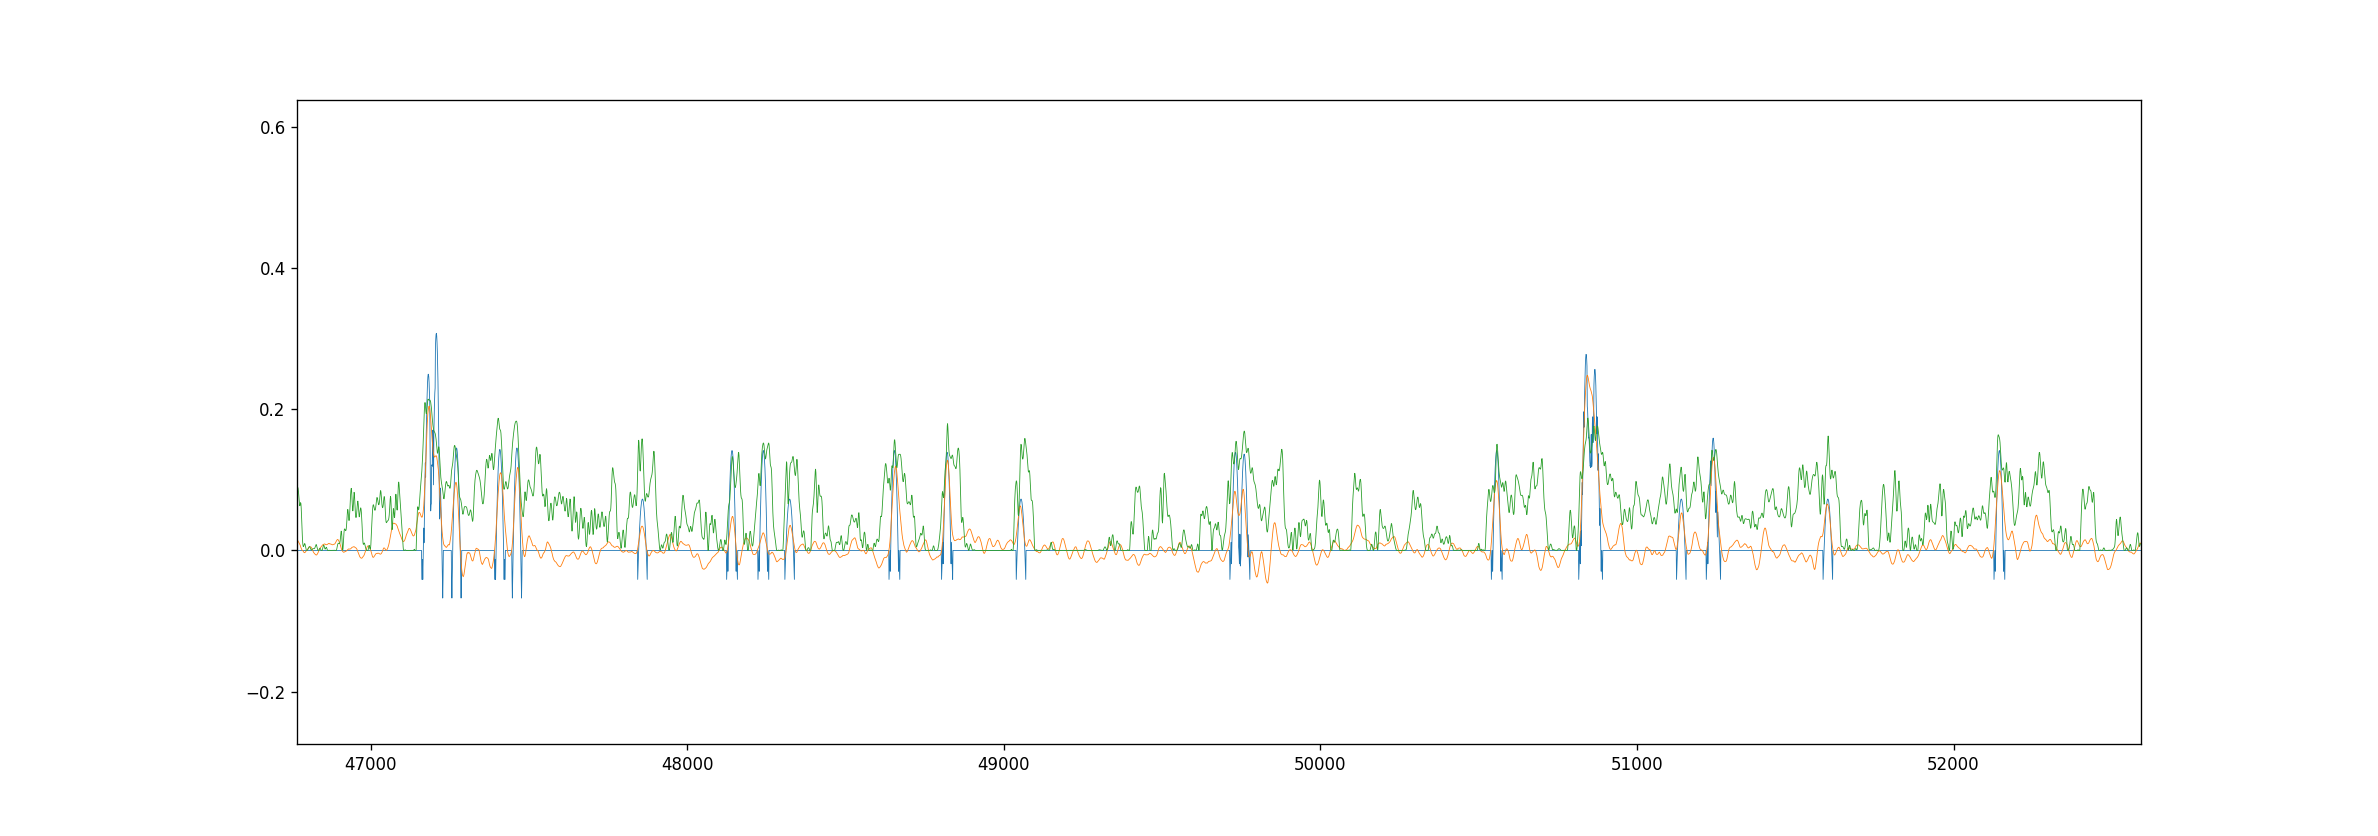

In [37]:
## Correlate to licking signal
# idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
# idx_nonRunning[:20000] = 0
# idx_nonRunning[60000:75000] = 0

# X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
X_input = spks[IsCell_ROIClassifier==True,:].T
X_input = scipy.signal.savgol_filter( X_input , 31 , 3 , axis=0)
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
# y_input = scipy.signal.savgol_filter( ws_licks_bool_S2pInd[idx_nonRunning] , 31 , 3 )
y_input = scipy.signal.savgol_filter( ws_licks_bool_S2pInd , 31 , 3 )

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)
plt.plot(temporalFactors_s2pInd[:,2]/10 , linewidth = 0.5)

In [39]:
theta_FF.shape
F_zscore_roll[:,IsCell_ROIClassifier==True].shape

(108000, 1005)

In [40]:
np.sum(IsCell_ROIClassifier)

1005

In [62]:
## Saving output ensembles
import scipy.io

factor_toUse_oneIdxed = 8

weights_RegressionAnalysisOutput = theta_FF[1:,factor_toUse_oneIdxed-1]

regression_output = {"regression_goalSignal": temporalFactors_s2pInd[:,factor_toUse_oneIdxed-1],
                     "regression_reconstruction":y_reconstructed_FF[:,factor_toUse_oneIdxed-1]
                    }

weights_day0 = {
  "weights": weights_RegressionAnalysisOutput,
  "iscell_custom": IsCell_ROIClassifier,
    "win_size_rollingBaseline": win_size_rollingBaseline,
    "factor_toUse_oneIdxed": factor_toUse_oneIdxed,
    "regression_output":regression_output,
}

dir_save = r'/media/rich/bigSSD RH/analysis_data/mouse 2_6/20210409'
save_name = 'weights_day0'
save_fullPath = f'{dir_save}{slash_type}weights_day0'

F = scipy.io.savemat(f'{save_fullPath}.mat' , weights_day0)

np.save(f'{save_fullPath}.npy' , weights_day0)

<IPython.core.display.Javascript object>


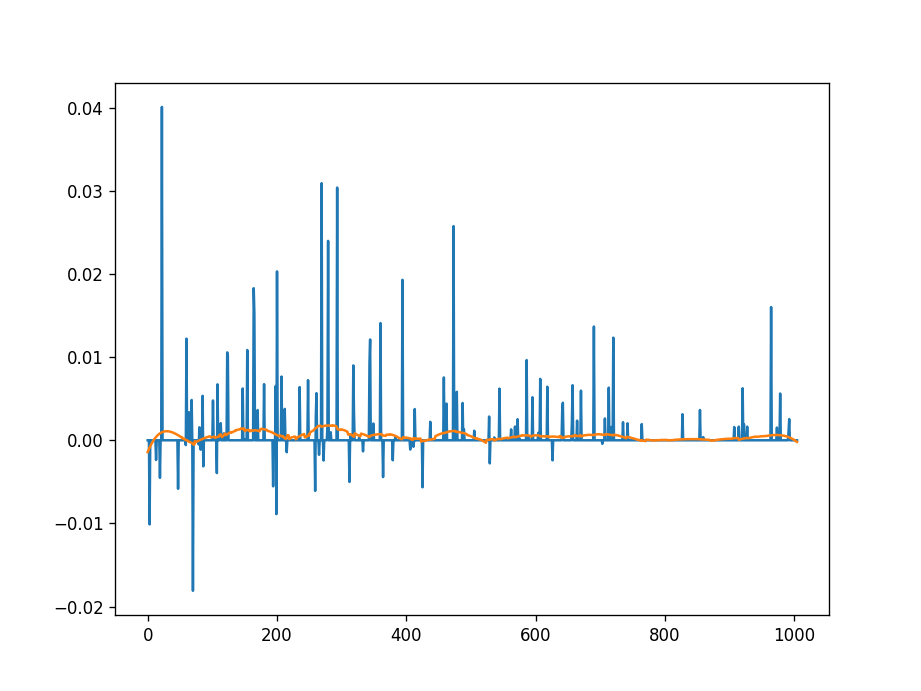

In [63]:
plt.figure()
plt.plot(weights_RegressionAnalysisOutput)
plt.plot(scipy.signal.savgol_filter(weights_RegressionAnalysisOutput , 101 , 3));